In [ ]:
# Note: this notebook is not finished, the current results are bad...
# In this notebook, we try to predict the RUL of each machine using a LSTM network
# in Pytorch Lightning
# The first step is to prepare the data using the results from Turbofan.ipynb
# Then, we prepare the time series and finally we train a model
# the predicted values are plot and compared 

In [28]:
import sys
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, dataloader, TensorDataset
from torch.utils.data import Subset
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback
from torch.autograd import Variable
import torchmetrics
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

In [29]:
source  = {}
source["train"] = ["./CMAPSSData/train_FD00{}.txt".format(i) for i in range(1, 5)]
source["test"] = ["./CMAPSSData/test_FD00{}.txt".format(i) for i in range(1, 5)]
source["rul"] = ["./CMAPSSData/RUL_FD00{}.txt".format(i) for i in range(1, 5)]

In [30]:
for k in source:
    print(k)
    for f in source[k]:
        print('{0: <4} {1}'.format('', f))

train
     ./CMAPSSData/train_FD001.txt
     ./CMAPSSData/train_FD002.txt
     ./CMAPSSData/train_FD003.txt
     ./CMAPSSData/train_FD004.txt
test
     ./CMAPSSData/test_FD001.txt
     ./CMAPSSData/test_FD002.txt
     ./CMAPSSData/test_FD003.txt
     ./CMAPSSData/test_FD004.txt
rul
     ./CMAPSSData/RUL_FD001.txt
     ./CMAPSSData/RUL_FD002.txt
     ./CMAPSSData/RUL_FD003.txt
     ./CMAPSSData/RUL_FD004.txt


In [31]:
columns_name = ['unit', 'cycle'] +\
    ["setting_{}".format(i) for i in range(3)] +\
    ["sensor_{}".format(i) for i in range(21)]

In [32]:
# function to prepare the data train
def prepare_data_train(file_path):
    # reading the file -> dataframe
    df_train_0 = pd.read_csv(file_path,
                         sep='\s+',
                         header=None,
                         names=columns_name)
    
    # list of significant columns (see Turbofane_EDA.ipynb)
    significant_columns_2 = ['unit', 'cycle', 'sensor_1', 'sensor_2', 'sensor_3',
                             'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 
                             'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 
                             'sensor_14', 'sensor_16', 'sensor_19', 'sensor_20']
    # list of units
    list_of_units = np.unique(df_train_0["unit"].values)
    
    # selecting the interesting columns
    df_train_0_reduce = df_train_0[significant_columns_2].copy()
    
    # calculating RUL
    dic_rul = {}
    for u in list_of_units:
        dic_rul[u] = np.max(df_train_0[df_train_0["unit"] == u]["cycle"].values)

    ruls_values = []
    for u in list_of_units:
        ruls_values += [dic_rul[u] - df_train_0[df_train_0["unit"] == u]["cycle"].values]
    ruls_values = np.concatenate(ruls_values, axis=0)
    df_train_0_reduce["RUL"] = ruls_values
    
    #spliting the data 
    U = df_train_0_reduce['unit'].values
    X = df_train_0_reduce[['cycle', 'sensor_1', 'sensor_2', 'sensor_3',
                             'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 
                             'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 
                             'sensor_14', 'sensor_16', 'sensor_19', 'sensor_20']].values
    Y = df_train_0_reduce['RUL'].values
    return (U, X, Y)

In [33]:
# function to normalize the data into [0, 1]
# we create a transformer for X and one for Y
# unit does not need it (only to split the data)
def normalize(X, Y):
    scalers = []
    values = []
    if len(Y.shape)==1:
        Y = np.expand_dims(Y, -1)
    for x in [X, Y]:
        scaler = preprocessing.MinMaxScaler()
        scaler.fit(x)
        x = scaler.transform(x)
        scalers += [scaler]
        values += [np.squeeze(x)]
    return scalers, values

In [34]:
# the main idea is to produce a dataset by machine, to allow cross-validation 
def transform_to_list_of_time_series(U, X, Y, windows=5):
    list_X = []
    list_Y = []
    list_of_units = np.unique(U)
    for u in list_of_units:
        idx = np.argwhere(U==u)  # indexes of rows for machine u
        Xi = np.squeeze(X[idx])
        Yi = Y[idx]
        data = np.concatenate([Xi, Yi], axis=1)
        datas = [(data[i :(i + windows), :-1], data[i + windows, -1]) for i in range(data.shape[0] - windows)]
        Xi, Yi = zip(*datas)
        Xi = np.array(Xi)
        Yi = np.array(Yi)
        list_X += [Xi]
        list_Y += [Yi]
    return list_X, list_Y

In [35]:
# spliting the dataset for cross-valisation
# unification of the different machine
def data_training_cross_val_old(list_X, list_Y, itr=0):
    tscv = TimeSeriesSplit()
    X_train = []
    X_test = []
    Y_train = []
    Y_test = []
    iNb = len(list_X)
    for i in range(iNb):
        idx_train = list(tscv.split(list_X[i]))[itr][0]
        idx_test = list(tscv.split(list_X[i]))[itr][1]
        X_train += [list_X[i][idx_train]]
        Y_train += [list_Y[i][idx_train]]
        X_test += [list_X[i][idx_test]]
        Y_test += [list_Y[i][idx_test]]
    X_train = np.concatenate(X_train, axis=0)
    Y_train = np.concatenate(Y_train, axis=0)
    X_test = np.concatenate(X_test, axis=0)
    Y_test = np.concatenate(Y_test, axis=0)
    return X_train, Y_train, X_test, Y_test

In [36]:
# spliting the dataset for cross-valisation
# unification of the different machine
def data_training_cross_val(list_X, list_Y, itr=0):
    kf = KFold(n_splits=5)
    idx = np.arange(len(list_X))
    idx_train, _ = list(kf.split(idx))[itr]
    X_train = []
    X_test = []
    Y_train = []
    Y_test = []
    for i in idx_train:
        X_train += [list_X[i]]
        Y_train += [list_Y[i]]
        X_test += [list_X[i]]
        Y_test += [list_Y[i]]
    X_train = np.concatenate(X_train, axis=0)
    Y_train = np.concatenate(Y_train, axis=0)
    X_test = np.concatenate(X_test, axis=0)
    Y_test = np.concatenate(Y_test, axis=0)
    return X_train, Y_train, X_test, Y_test

In [37]:
# definion of the model
class Model(pl.LightningModule):
    def __init__(self, dim_output, input_size, hidden_size, num_layers, window,lr=0.0002):
        super().__init__()
        self.save_hyperparameters()

        self.lr = lr
        self.dim_output = dim_output
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.window = window
        # self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size * num_layers, dim_output)
        self.criterion = torch.nn.MSELoss()
        self.datas = {'loss':{'train':[], 'test':[]}}
        # self.fig, self.axs = monitoring(self.datas, x_max=10, y_max=100, column_max=3)
        
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        _, (out, _)  = self.lstm(x, (h_0, c_0))
        out = out.view(-1, self.hidden_size * self.num_layers)
        out = self.fc(out)
        return out
    
    def training_step(self, batch, batch_idx):
        (x, y) = batch
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        # self.datas['loss']['train'] += [loss.detach().numpy()]
        # monitoring_update(self.fig, self.axs, self.datas)
        return {'loss':loss}
    
    def training_epoch_end(self, outputs):
        loss_val = torch.stack([x['loss'] for x in outputs]).mean()
        self.datas['loss']['train'] += [loss_val.detach().numpy()]
        # log_dict = {'training_loss': loss_val, 'step': self.current_epoch}
        # return {'log': log_dict}
    
    def validation_step(self, batch, batch_idx):
        (x, y) = batch
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        # self.datas['loss']['test'] += [loss.detach().numpy()]
        # monitoring_update(self.fig, self.axs, self.datas)
        return {'val_loss': loss}
    
    def validation_epoch_end(self, outputs):
        loss_val = torch.stack([x['val_loss'] for x in outputs]).mean()
        self.datas['loss']['test'] += [loss_val.detach().numpy()]

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.lr)
        return opt

In [38]:
# transforming data into loaders
# creation of dataset
def transform_to_loader(X, Y, batch=16, num_workers=2):
    if len(Y.shape) == 1:
        Y = np.expand_dims(Y, -1)
    ts_x = torch.Tensor(X) 
    ts_y = torch.Tensor(Y)
    dataset = TensorDataset(ts_x,ts_y)
    loader = DataLoader(dataset, batch_size=batch,
                        num_workers=num_workers)
    return loader

In [39]:
window = 20
file_path = source["train"][0]
(U, X, Y) = prepare_data_train(file_path)
scalers, values = normalize(X, Y)
list_X, list_Y = transform_to_list_of_time_series(U, values[0], values[1], window)
# spliting the data
X_train, Y_train, X_test, Y_test = data_training_cross_val(list_X, list_Y, itr=3)
print("input shape: {}".format(X_train.shape))
print("output shape: {}".format(Y_train.shape))

input shape: (14835, 20, 16)
output shape: (14835,)


In [40]:
# defining loaders...
batch = 16
num_workers = 2
train_loader = transform_to_loader(X_train, Y_train, batch, num_workers)
val_loader = transform_to_loader(X_test, Y_test, batch, num_workers)

In [41]:
# defining a lstm model
input_size = 16
hidden_size = 5
num_layers = 2
dim_output = 1
learning_rate = 0.0001
net = Model(dim_output, input_size, hidden_size, num_layers, window, lr=learning_rate)
print(net)
summary(net, input_size=(batch, window, 16))

Model(
  (lstm): LSTM(16, 5, num_layers=2, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
  (criterion): MSELoss()
)


Layer (type:depth-idx)                   Output Shape              Param #
Model                                    --                        --
├─LSTM: 1-1                              [16, 20, 5]               700
├─Linear: 1-2                            [16, 1]                   11
├─MSELoss: 1-3                           --                        --
Total params: 711
Trainable params: 711
Non-trainable params: 0
Total mult-adds (M): 0.22
Input size (MB): 0.02
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.04

In [42]:
# training the model
num_epochs = 30
trainer = Trainer(max_epochs=num_epochs, 
                  auto_lr_find=True)
trainer.fit(net, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type    | Params
--------------------------------------
0 | lstm      | LSTM    | 700   
1 | fc        | Linear  | 11    
2 | criterion | MSELoss | 0     
--------------------------------------
711       Trainable params
0         Non-trainable params
711       Total params
0.003     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/medialdea/Documents/Pytorch/VE/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/medialdea/Documents/Pytorch/VE/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

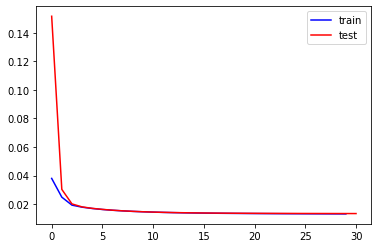

In [43]:
# plot the losses...
plt.plot(net.datas['loss']['train'], 'b', label="train")
plt.plot(net.datas['loss']['test'], 'r', label="test")
plt.legend()
plt.show()

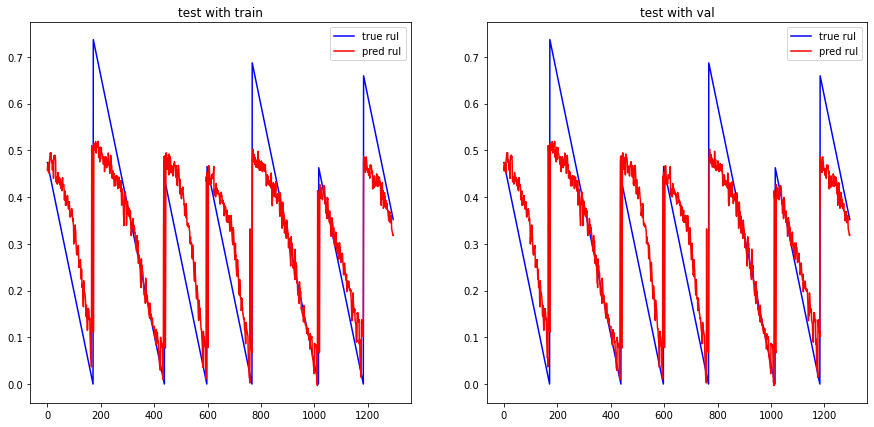

In [46]:
# testing
plt.rcParams['figure.figsize'] = [15, 7]
def testing(loader):
    y_true = []
    y_pred = []
    limit = 80
    it = 0
    for x, y in loader:
        y_true += [np.squeeze(y.numpy())]
        y_pred += [np.squeeze(net(x).detach().numpy())]
        it += 1
        if it > limit:
            break
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)
    return y_true, y_pred

y_train_true, y_train_pred = testing(train_loader)
y_val_true, y_val_pred = testing(val_loader)

plt.subplot(121)
plt.plot(y_train_true, 'b', label="true rul")
plt.plot(y_train_pred, 'r', label="pred rul")
plt.legend()
plt.title('test with train')
plt.subplot(122)
plt.plot(y_val_true, 'b', label="true rul")
plt.plot(y_val_pred, 'r', label="pred rul")
plt.legend()
plt.title('test with val')
plt.show()

In [ ]:
# The results are bad in large part of the time series...